In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.io import savemat, loadmat
from nilearn import datasets, plotting, image

**Loading atlas**

In [2]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas['maps']
labels = atlas['labels']
coords = atlas['region_coords']
print(labels, len(labels))

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS'] 39


In [3]:
names_map = {val: i for i, val in enumerate(labels)}

**Loading connectivity data**

In [4]:
data = pd.read_csv('./datasets/func_conn.csv')
data.head()

,file,ID,target,Sex,L Aud-R Aud,L Aud-Striate,R Aud-Striate,L Aud-L DMN,R Aud-L DMN,Striate-L DMN,...,Broca-R Ant IPS,Sup Front S-R Ant IPS,R TPJ-R Ant IPS,R Pars Op-R Ant IPS,Cereb-R Ant IPS,Dors PCC-R Ant IPS,L Ins-R Ant IPS,Cing-R Ant IPS,R Ins-R Ant IPS,L Ant IPS-R Ant IPS
0,morphometry_A00007409,A00007409,No_Known_Disorder,male,0.852745,0.472408,0.438451,-0.151586,-0.175817,-0.088072,...,0.157520,0.111554,0.024794,0.074087,0.083605,0.332223,0.299678,0.378165,0.238186,0.633913
1,morphometry_A00031597,A00031597,Schizophrenia_Strict,male,0.748457,0.532091,0.617542,0.090878,0.043540,-0.036074,...,0.374588,0.340460,0.342494,0.249617,0.382124,0.604362,0.168657,0.284299,0.183674,0.626664
2,morphometry_A00022500,A00022500,Schizophrenia_Strict,female,0.592125,0.036093,0.133537,0.082847,0.179051,0.314248,...,-0.253343,-0.049419,0.103218,-0.098405,-0.106043,0.359292,-0.283070,0.194902,-0.112684,0.582636
3,morphometry_A00024953,A00024953,Schizophrenia_Strict,male,0.780837,0.354871,0.420179,0.144601,0.208352,0.168114,...,0.190040,-0.012739,-0.038590,0.150418,0.043712,0.165942,-0.003737,0.316817,-0.003129,0.633039
4,morphometry_A00001251,A00001251,Schizophrenia_Strict,male,0.447026,-0.024045,0.432331,-0.247530,0.113947,0.412405,...,-0.240672,0.271395,-0.054881,0.044233,0.063376,0.387130,0.145573,0.396055,0.112810,0.532662


In [5]:
def get_adjmat(patient):
    connectivity_mat = np.zeros((len(labels), len(labels)))
    for i, name1 in enumerate(names_map.keys()):
        for name2 in list(names_map.keys())[(i+1):]: # skipping past and skipping itself
            col_name = f'{name1}-{name2}' if f'{name1}-{name2}' in patient.columns else None
            col_name = f'{name2}-{name1}' if (f'{name2}-{name1}' in patient.columns and col_name is None) else col_name
            if col_name is not None:
                connectivity_mat[names_map[name1]][names_map[name2]] = patient[col_name]
                connectivity_mat[names_map[name2]][names_map[name1]] = patient[col_name]
                
    return connectivity_mat

**Connectivity matrix example**

In [6]:
patient_0 = pd.DataFrame(data.iloc[0]).T

In [7]:
connectivity_mat = get_adjmat(patient_0)
print(connectivity_mat.shape)

(39, 39)


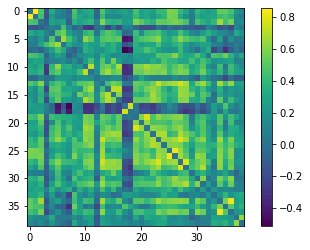

In [8]:
plt.imshow(connectivity_mat)
plt.colorbar()

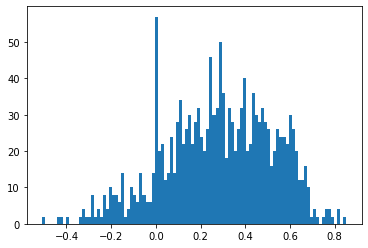

In [9]:
plt.hist(connectivity_mat.reshape(-1), bins=100);

In [10]:
rois = pd.read_csv('./msdl_rois_labels.csv')
rois.name = [name.strip() for name in rois.name]
rois['net name'] = [name.strip() for name in rois['net name']]

pd.DataFrame(rois).drop(['x', 'y', 'z'], axis=1).to_csv('./datasets/Schiza_Community.csv')


In [11]:
cluster_names = {val: i for i, val in enumerate(np.unique(rois['net name']))}
cluster_names

{'Ant IPS': 0,
 'Aud': 1,
 'Basal': 2,
 'Cereb': 3,
 'Cing-Ins': 4,
 'D Att': 5,
 'DMN': 6,
 'Dors PCC': 7,
 'L V Att': 8,
 'Language': 9,
 'Motor': 10,
 'Occ post': 11,
 'R V Att': 12,
 'Salience': 13,
 'Striate': 14,
 'Temporal': 15,
 'Vis Sec': 16}

In [12]:
with open('./datasets/Schiza.txt', 'w') as f:
    for name in names_map.keys():
        tmp = rois[rois.name == name].to_numpy().ravel()
        f.write(f'{tmp[0]}\t{tmp[1]}\t{tmp[2]}\t{cluster_names[tmp[-1]]}\t1\t{names_map[name]}\t\n')


**IBGNN input**
* Connectivity matrices
* Node labels, format: txt, file with rows: (x, y, z), node color (label), node size, region name
* Community, format: csv, file with rows: id, node label, community label (for heatmap)

In [13]:
targets = data['target']

In [14]:
np.unique(targets)

array(['No_Known_Disorder', 'Schizoaffective', 'Schizophrenia_Strict'],
      dtype=object)

In [15]:
data_schizastrict = data.drop(data[data['target'] == 'Schizoaffective'].index, axis='index')
targets_schizastrict = data_schizastrict['target']
targets_bin = [1. if ('Schizo' in l) else 0. for l in targets_schizastrict]

In [16]:
connectivity_data = np.asarray(list([get_adjmat(pd.DataFrame(data_schizastrict.iloc[i]).T) for i in range(data_schizastrict.shape[0])]))
print(connectivity_data.shape)

(152, 39, 39)


In [17]:
savemat('./datasets/Schiza.mat', {'label': targets_bin, 'dti': connectivity_data.T})

**Run cross validation**

In [ ]:
!cd ./IBGNN && python main_explainer.py --cross_val --k_fold_splits=3 \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza --explain


**K Fold training, k = 7**

| K Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=61.18 +-  5.30, avg_auc=64.04 +- 5.59, avg_macro=60.12 +- 5.28|
|(K Fold Tuning) | avg_acc=63.82 +-  10.72, avg_auc=67.10 +- 9.96avg_macro=63.38 +- 10.75|

**K Fold training, k = 5**

| K Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=64.68 +-  5.39, avg_auc=66.52 +- 5.30, avg_macro=63.91 +- 5.65|
|(K Fold Tuning) | avg_acc=67.72 +-  3.56, avg_auc=71.08 +- 2.99avg_macro=67.63 +- 3.49|


**K Fold training, k = 3**

| F Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=59.29 +-  10.34, avg_auc=60.47 +- 10.67, avg_macro=58.77 +- 10.39|
|(K Fold Tuning) | avg_acc=61.23 +-  8.65, avg_auc=65.58 +- 11.96avg_macro=60.30 +- 8.16|

**K Fold training, k = 10**

| F Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=61.69 +-  10.11, avg_auc=65.21 +- 13.82, avg_macro=60.31 +- 10.09|
|(K Fold Tuning) | avg_acc=62.38 +-  10.65, avg_auc=64.89 +- 14.24avg_macro=61.62 +- 10.74|

**Run Training + extracting explaination**

In [18]:
!cd ./IBGNN && python main_explainer.py --train --explain --save_explanation \
 --initial_epochs 100 --tuning_epochs 100 --test_interval 50 \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


[1, 1, 14, 6, 6, 6, 6, 11, 10, 12, 12, 12, 12, 2, 8, 8, 8, 5, 5, 16, 16, 16, 13, 13, 13, 15, 15, 9, 9, 9, 9, 9, 3, 7, 4, 4, 4, 0, 0] 39
seed for seed_everything(): 112078
Training 80/20 

/root/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
(Initial Train) | Epoch=000, loss=50.3115, 
train_micro=47.11, train_macro=47.02, train_auc=47.37
(Initial Train) | Epoch=001, loss=32.7708, 
train_micro=47.93, train_macro=47.88, train_auc=47.85
(Initial Train) | Epoch=002, loss=21.9280, 
train_micro=51.24, train_macro=50.76, train_auc=53.18
(Initial Train) | Epoch=003, loss=19.3580, 
train_micro=55.37, train_macro=54.47, train_auc=55.40
(Initial Train) | Epoch=004, loss=12.2000, 
train_micro=57.02, train_macro=57.02, train_auc=59.65
(Initial Train) | Epoch=005, loss=10.9657, 
train_micro=57.85, train_macro=57.56, train_auc=60.96
(Initial Train) | Epoch=006, loss=7.3302, 
tra

(Initial Train) | Epoch=080, loss=0.0704, 
train_micro=83.47, train_macro=83.28, train_auc=99.15
(Initial Train) | Epoch=081, loss=0.1333, 
train_micro=97.52, train_macro=97.51, train_auc=99.34
(Initial Train) | Epoch=082, loss=0.0401, 
train_micro=97.52, train_macro=97.51, train_auc=99.42
(Initial Train) | Epoch=083, loss=0.0771, 
train_micro=89.26, train_macro=88.95, train_auc=95.33
(Initial Train) | Epoch=084, loss=0.1584, 
train_micro=93.39, train_macro=93.31, train_auc=97.81
(Initial Train) | Epoch=085, loss=0.1371, 
train_micro=96.69, train_macro=96.69, train_auc=98.45
(Initial Train) | Epoch=086, loss=0.1375, 
train_micro=72.73, train_macro=71.41, train_auc=96.44
(Initial Train) | Epoch=087, loss=0.5006, 
train_micro=90.08, train_macro=90.08, train_auc=95.93
(Initial Train) | Epoch=088, loss=0.3690, 
train_micro=79.34, train_macro=77.79, train_auc=82.91
(Initial Train) | Epoch=089, loss=0.1988, 
train_micro=85.95, train_macro=85.38, train_auc=90.12
(Initial Train) | Epoch=090, l

(Tuning Train) | Epoch=059, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=060, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=061, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=062, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=063, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=064, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=065, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=066, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=067, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=068, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Tr

In [19]:
general_edge_mask = np.load('IBGNN/edge_mask.npy')
general_node_mask = np.load('IBGNN/node_feat_mask.npy')

In [20]:
general_node_mask

array([0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854], dtype=float32)

In [21]:
for i in range(general_edge_mask.shape[0]):
    general_edge_mask[i][i] = 0.0

Text(0.5, 1.0, 'edge mask * connectivity thresholded')

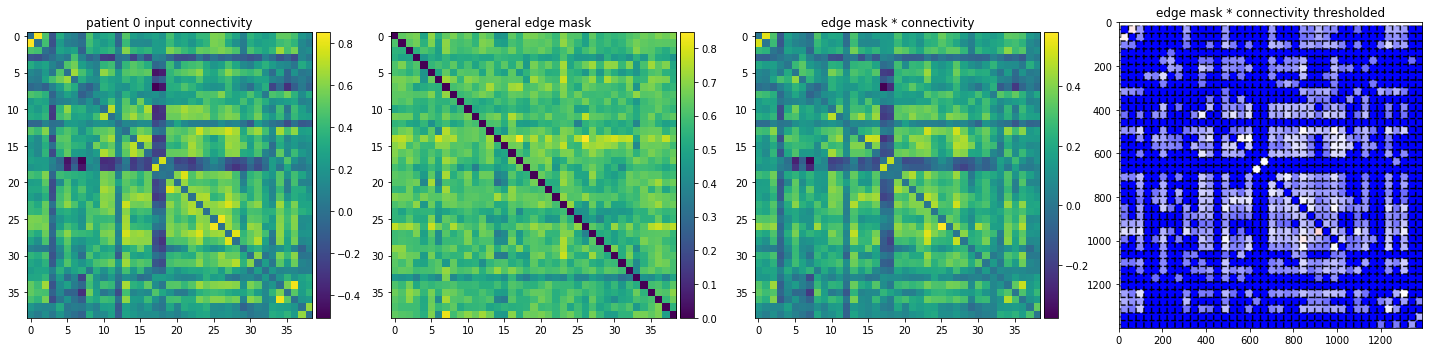

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 4, figsize=(25, 25))

im0 = axs[0].imshow(connectivity_mat)
axs[0].set_title('patient 0 input connectivity')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical');

im1 = axs[1].imshow(general_edge_mask)
axs[1].set_title('general edge mask')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');


im2 = axs[2].imshow(general_edge_mask*connectivity_mat)
axs[2].set_title('edge mask * connectivity')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

axs[3].imshow(plt.imread('./IBGNN/fig/explained_Schiza_seed112078_negative_0_heatmap.png')[200:1600, 530:1920])
axs[3].set_title('edge mask * connectivity thresholded')



On the group level, we rank the most salient ROIs on the learned explanation mask by calculating the sum of the edge weights connected to each node. Then on the individual level, we use the BrainNet Viewer [37] to plot the salient ROIs on the average brain connectivity graph enhanced by the learned explanation mask.

In [23]:
# group level: to rank most salient ROIs on the explanation mask, 
#              we calculate the sum of the edge weights connected to each node.
print('group level ranking')
ranking = {}
for i, row in enumerate(connectivity_mat):
    ranking[list(names_map.keys())[i]] = sum(abs(row))
    
print(*enumerate(sorted(ranking.items(), key=lambda a: a[1])), sep='\n')

group level ranking
(0, ('L DMN', 4.412778685763514))
(1, ('R Post Temp', 4.564337984345164))
(2, ('R IPS', 6.6194636911877724))
(3, ('R Ant IPS', 6.892999651541974))
(4, ('L Ant IPS', 7.043793708263955))
(5, ('Dors PCC', 7.060439531596598))
(6, ('L IPS', 7.681242379859502))
(7, ('Cereb', 8.620605851575458))
(8, ('Occ post', 8.732711710210413))
(9, ('Sup Front S', 8.925064758578195))
(10, ('R DMN', 9.67702173520284))
(11, ('R DLPFC', 9.931524799444018))
(12, ('Med DMN', 10.341535309358603))
(13, ('R Aud', 10.72997096642094))
(14, ('Cing', 10.745197488890483))
(15, ('Motor', 11.209664287056471))
(16, ('L Aud', 12.204024334656658))
(17, ('R TPJ', 12.5831745683751))
(18, ('R Ins', 13.414924095134708))
(19, ('Front DMN', 13.503590152916711))
(20, ('Vis', 13.607217158627662))
(21, ('L DLPFC', 13.90003761729684))
(22, ('Striate', 14.082956257819077))
(23, ('L Front pol', 14.189054328033835))
(24, ('L Par', 14.394006724431966))
(25, ('R Pars Op', 14.798776943725906))
(26, ('L LOC', 14.8599207

### Illustrating ROIs

In [28]:
import os

folder = '/home/neuro-gnn-project/rois/'
if not os.path.exists(folder):
    os.mkdir(folder)

for i in range(len(labels)):
    nib.save(image.index_img(atlas_filename, 0), folder+'_'.join(labels[i].split(' '))+'.nii')

In [26]:
nib.save(image.index_img(atlas_filename, slice(0, 3)), './test.nii')

/root/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


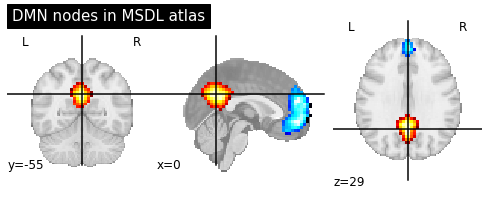

In [261]:
from nilearn import plotting, image

# First plot the map for the PCC: index 4 in the atlas
display = plotting.plot_stat_map(image.index_img(atlas_filename, 4),
                                 colorbar=False,
                                 title="DMN nodes in MSDL atlas")

# Now add as an overlay the maps for the ACC and the left and right
# parietal nodes
display.add_overlay(image.index_img(atlas_filename, 5),
                    cmap=plotting.cm.black_blue)
display.add_overlay(image.index_img(atlas_filename, 10),
                    cmap=plotting.cm.black_green)
# display.add_overlay(image.index_img(atlas_filename, 3),
#                     cmap=plotting.cm.black_pink)

plotting.show()